Change Modeling for Soil Carbon Accounting
------------------------------------------

This notebook generates prediction and uncertainty maps for the change of soil properties within a certain period of time. The use-case goal for this example is to model the change of the Organic Carbon (OC) stock volume for a farm. A particular focus is to model the uncertainty of the change, which needs to take into account the covariances of the prediction in space and time.

The model training data is based on laboratory measurements of Organic Carbon stock for 2018 and 2021 from sample sites in L'lara.  

The prediction model is a Gaussian Process regression model with Bayesian Linear Regression (BLR) or Random Forest (RF) as base function. Here we use a squared exponential GP kernel with two joint length-scales, one for spatial and one for temporal distance (see optimized hyperparameters of the GP below).

### Change Calculation

The change of the soil property OC ($\delta OC(t2-t1)$) between two different dates, t1 and t2, is given by:

$ \delta OC(x,y,t2-t1) = OC(x,y,t2) - OC(x,y,t1) $, 

while the variance of the change is: 

$ var[\delta OC(x,y,t2-t1)] = var[OC(x,y,t1)] + var[OC(x,y,t2)] - 2 \Sigma[OC(x,y,t1),OC(x,y,t2)]$

where $\Sigma[OC(x,y,t1),OC(x,y,t2)]$ is the covariance matrix between $OC(x,y,t1)$ and $OC(x,y,t2)$. 

### Notebook Outline

The notebook will showcase a typical analysis workflow:

- Feature exploration and selection
- Model selection and validation
- Generating model predictions

For each workflow process we will run a Python script with settings defined in a settings yaml file.


This package is part of the machine learning project developed for the Agricultural Research Federation (AgReFed).



## Library imports

In [1]:
# Import libraries
import os 
import sys
import yaml
import shutil
from types import SimpleNamespace  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from selectio import selectio

# Import custom modules 
sys.path.append('../python_scripts')
from preprocessing import gen_kfold
import soilmod_predict_change as soilmod
import soilmod_xval as xval

## 1) Feature importance and selection

 ### Settings file

 All settings are specified in the .yaml file to make analysis reproducible.

In [47]:
# Define name of settings file to save configuration
fname_settings = 'settings_featureimportance_OC.yaml'
path_settings = 'settings'

### Read and process feature importance settings

In [48]:
# Load settings from yaml file
with open(os.path.join(path_settings,fname_settings), 'r') as f:
    settings = yaml.load(f, Loader=yaml.FullLoader)
# Parse settings dictionary as namespace (settings are available as 
# settings.variable_name rather than settings['variable_name'])
settings = SimpleNamespace(**settings)

# Verify output directory and make it if it does not exist
os.makedirs(settings.outpath, exist_ok = True)

print("Main Settings:")
print("----------------")
for key in settings.__dict__:
    if key != "name_features":
        print(f"settings.{key} : {settings.__dict__[key]}")

# Print features selected
print("")
print("Available Features:")
print("----------------")
for key in settings.__dict__:
    if key == "name_features":
        for feature in settings.name_features:
            print(f"'{feature}'")

Main Settings:
----------------
settings.inpath : ../../../data/Llara/OC_data_2018_2021/
settings.infname : OC_NDVI_data_final.csv
settings.outpath : ../../../results/Llara_OC_2018_2021_featureimportance/
settings.name_target : OC.WB

Available Features:
----------------
'DEM_30'
'SlopeDeg'
'rad_dose'
'rad_u'
'NDVI_1yr'
'NDVI_3yr'


### Read in data

Coordinate origin (projected crs): 771269.9, 6646153.7


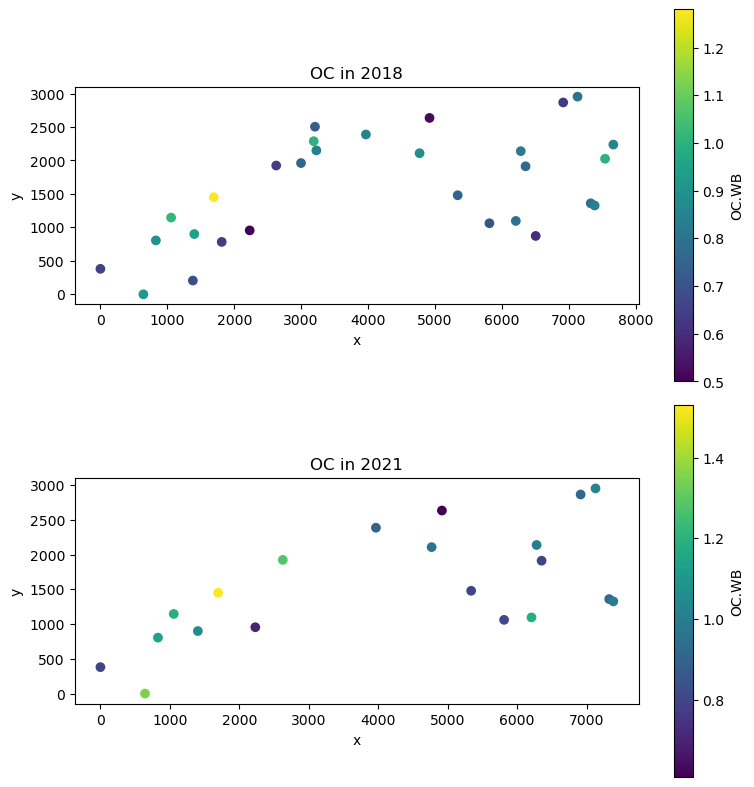

In [62]:
# Read data
data_fieldnames = settings.name_features + [settings.name_target]
df = pd.read_csv(os.path.join(settings.inpath, settings.infname))

xmin = df['x'].min()
ymin = df['y'].min()
print(f'Coordinate origin (projected crs): {xmin:.1f}, {ymin:.1f}')

# Scatter plot of OC as function of x and y position
fig, ax = plt.subplots(2,1, figsize = (8,8))
df18 = df[df['year'] == 2018]
ax[0].scatter(df18['x'] - xmin, df18['y']- ymin, c = df18[settings.name_target], cmap = 'viridis')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('OC in 2018')
# set axis equal
ax[0].set_aspect('equal')
# plor colorbar
cbar = fig.colorbar(ax[0].collections[0], ax = ax[0])
cbar.set_label(settings.name_target)
df21 = df[df['year'] == 2021]
ax[1].scatter(df21['x']- xmin, df21['y'] - ymin, c = df21[settings.name_target], cmap = 'viridis')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_title('OC in 2021')
ax[1].set_aspect('equal')
cbar = fig.colorbar(ax[1].collections[0], ax = ax[1])
cbar.set_label(settings.name_target)
plt.tight_layout()
plt.show()

### Info about features

In [63]:
df = df[data_fieldnames].copy()

# Verify that data is cleaned:
assert df.select_dtypes(include=['number']).columns.tolist().sort() == data_fieldnames.sort(), 'Data contains non-numeric entries.'
assert df.isnull().sum().sum() == 0, "Data is not cleaned, please run preprocess_data.py before"

# Print data information
print("")
print("Data Information:")
print("----------------")
print(f"df.shape: {df.shape}")
print(f"df.columns: {df.columns.tolist()}")
print(f"df.head():")
print(df.head())


Data Information:
----------------
df.shape: (49, 7)
df.columns: ['DEM_30', 'SlopeDeg', 'rad_dose', 'rad_u', 'NDVI_1yr', 'NDVI_3yr', 'OC.WB']
df.head():
       DEM_30  SlopeDeg   rad_dose     rad_u  NDVI_1yr  NDVI_3yr  OC.WB
0  244.701126  0.960313  33.794144  0.640346  0.239335  0.179527   1.00
1  264.256927  0.640615  38.755341  1.110678  0.226007  0.192714   0.82
2  233.365417  0.549989  29.715052  0.692293  0.145816  0.167729   0.64
3  231.243744  1.048700  23.777195  0.598982  0.187475  0.187475   1.02
4  234.767990  0.309102  33.577145  0.374206  0.192652  0.192652   1.28


### Run feature selection

In [67]:
# Run selectio main 
selectio.main(os.path.join(path_settings, fname_settings))

Calculate Spearman correlation matrix...
Computing scores for model spearman...
Done, 6 features selected.
Computing scores for model mi...
Done, 5 features selected.
Computing scores for model xicor...
Done, 2 features selected.
Computing scores for model blr...
Done, 6 features selected.
Computing scores for model rf...
Done, 6 features selected.
Computing scores for model rdt...
Done, 6 features selected.
Feature selection: 
  name_features  score_combined
2      rad_dose          0.3069
4      NDVI_1yr          0.2600
3         rad_u          0.1997
0        DEM_30          0.1032
1      SlopeDeg          0.0842
5      NDVI_3yr          0.0460
Generating overview score plots ...
COMPLETED.
Completed


In [68]:
# inspect results
dfresults = pd.read_csv(os.path.join(settings.outpath,'feature-importance_scores.csv'), index_col='Feature_index')
dfresults

,name_features,score_spearman,score_mi,score_xicor,score_blr,score_rf,score_rdt,woe_spearman,woe_mi,woe_xicor,woe_blr,woe_rf,woe_rdt,score_combined,selected
Feature_index,,,,,,,,,,,,,,,
0,DEM_30,0.0,0.0479,0.0000,0.0,0.2237,0.1412,1,1,0,1,1,1,0.1032,1
1,SlopeDeg,0.0,0.0938,0.0000,0.0,0.1457,0.0971,1,1,0,1,1,1,0.0842,1
2,rad_dose,0.0,0.3297,0.6397,0.0,0.1311,0.1272,1,1,1,1,1,1,0.3069,1
3,rad_u,0.0,0.0411,0.3603,0.0,0.1288,0.2687,1,1,1,1,1,1,0.1997,1
4,NDVI_1yr,0.0,0.4875,0.0000,0.0,0.3106,0.2419,1,1,0,1,1,1,0.2600,1
5,NDVI_3yr,0.0,0.0000,0.0000,0.0,0.0601,0.1238,1,0,0,1,1,1,0.0460,1


### Show Spearman correlation matrix and feature clusters

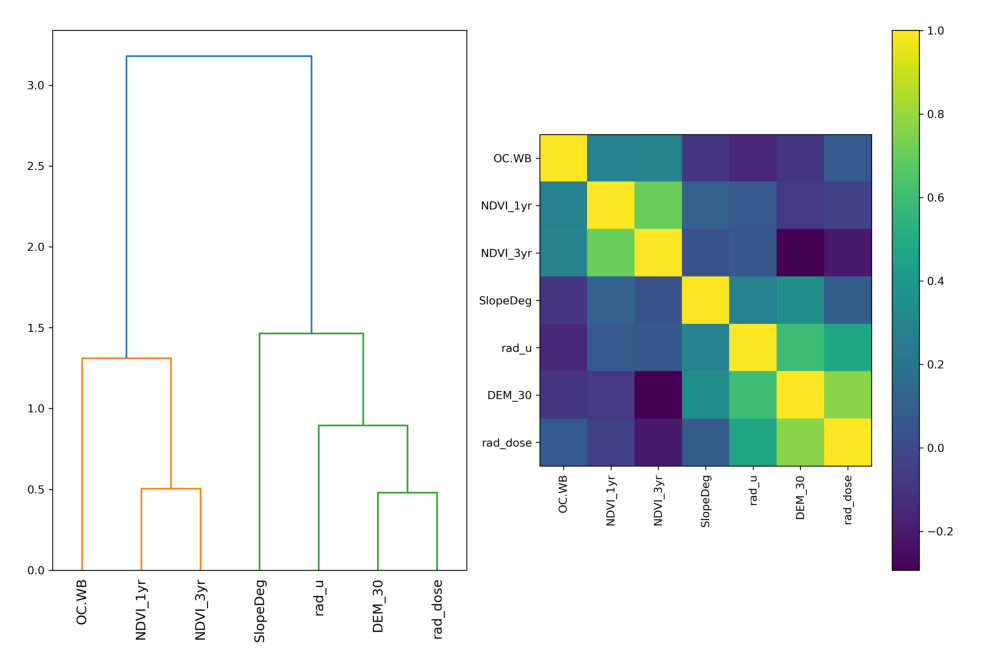

In [72]:
filename = 'Feature_Correlations_Hierarchical_Spearman.png'
img = imread(f"{settings.outpath}/{filename}", format='PNG')
fig = plt.figure(dpi=150)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
plt.imshow(img)



### Show feature importance scores 

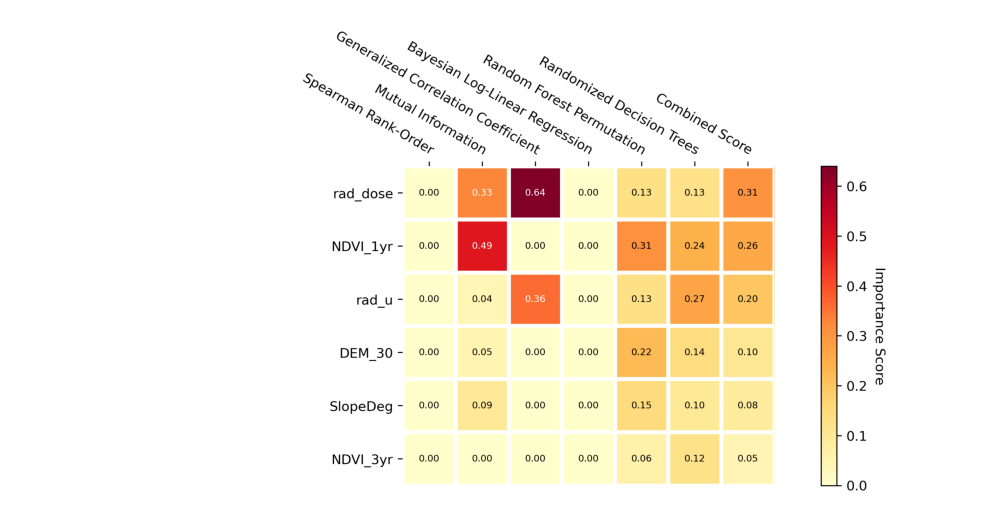

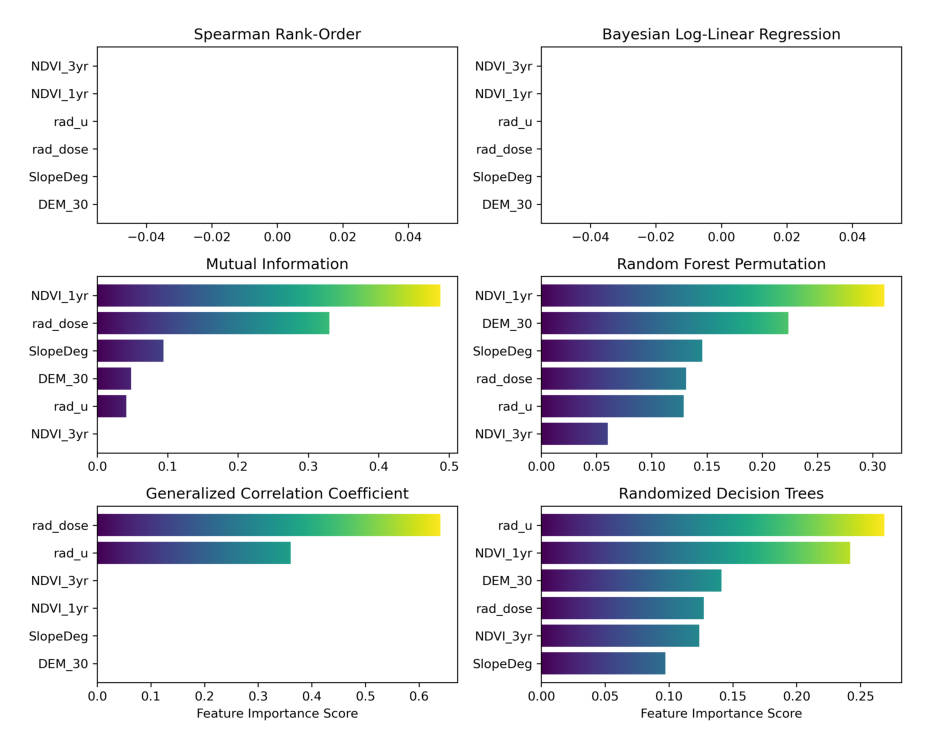

In [74]:
# show importance matrix
filename = 'Feature_importance_map.png'
img = imread(f"{settings.outpath}/{filename}", format='PNG')
fig = plt.figure(dpi=150)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
plt.imshow(img)
plt.show()

# show detailed plots
filename = 'Feature_importances_all.png'
img = imread(f"{settings.outpath}/{filename}", format='PNG')
fig = plt.figure(dpi=150)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
plt.imshow(img)
plt.show()

### Conclusions from feature importance modeling

- largest feature score: rad_dose
- smallest feature score: NDVI_3yr
- linear combination models (log-power BLR and Spearman) reveal no significant features (below sigificant treshold).
- exclude NDVI_3yr from selection because it has smallest score and is partially correlated with the more important feature NDVI_1yr

Final feature selection for subsequent analysis:
- rad_dose
- NDVI_1yr
- SlopeDeg
- rad_u
- DEM_30

Note that a common ranking trend of features between different models is missing and that no significant features are found at all in two of the model. This might indicate that current available feature data carries not much information value for OC prediction. In the next section we will test multiple models and their predictive power in more detail.

## 2) Model selection and cross-validation

### Read and process settings for model selection

In [75]:
# Settings name
fname_settings = 'settings_soilmod_xval_OC.yaml'

# Load settings from yaml file
with open(os.path.join(path_settings,fname_settings), 'r') as f:
    settings = yaml.load(f, Loader=yaml.FullLoader)
# Parse settings dictinary as namespace (settings are available as 
# settings.variable_name rather than settings['variable_name'])
settings = SimpleNamespace(**settings)

# Add temporal or vertical component
if settings.axistype == 'temporal':
    settings.colname_zcoord = settings.colname_tcoord
    settings.colname_zmin = settings.colname_tmin
    settings.colname_zmax =  settings.colname_tmax

if type(settings.model_functions) != list:
    settings.model_functions = [settings.model_functions]

# check if outpath exists, if not create direcory
os.makedirs(settings.outpath, exist_ok = True)

# Intialise output info file:
print(f'--- Parameter Settings ---')
print(f'Selected Model Functions: {settings.model_functions}')
print(f'Target Name: {settings.name_target}')
print(f'--------------------------')

# Print features selected
print("")
print("--- Features Selected ---")
for key in settings.__dict__:
    if key == "name_features":
        for feature in settings.name_features:
            print(f"'{feature}'")

--- Parameter Settings ---
Selected Model Functions: ['rf', 'rf-gp', 'blr', 'blr-gp']
Target Name: OC.WB
--------------------------

--- Features Selected ---
'DEM_30'
'SlopeDeg'
'rad_dose'
'rad_u'
'NDVI_1yr'


### Data Preprocessing

This includes reading in the dataset from .csv file into pandas dataframe, generating cross-validation test sets, and settings spatial-temporal boundaries.

In [76]:
print('Reading data into dataframe...')
# Read in data
dfsel = pd.read_csv(os.path.join(settings.inpath, settings.infname))

# Rename x and y coordinates of input data
if settings.colname_xcoord != 'x':
    dfsel.rename(columns={settings.colname_xcoord: 'x'}, inplace = True)
if settings.colname_ycoord != 'y':
    dfsel.rename(columns={settings.colname_ycoord: 'y'}, inplace = True)
if (settings.axistype == 'vertical') & (settings.colname_zcoord != 'z'):
    dfsel.rename(columns={settings.colname_zcoord: 'z'}, inplace = True)
else:
    dfsel.rename(columns={settings.colname_tcoord: 'z'}, inplace = True)
    dfsel.rename(columns={settings.colname_zcoord: 'z'}, inplace = True)
settings.name_features.append('z')

# Select data between zmin and zmax
dfsel = dfsel[(dfsel['z'] >= settings.colname_zmin) & (dfsel['z'] <= settings.colname_zmax)]

# Generate n-fold indices
print(f'Generating {settings.nfold}-fold test sets based on moisture probe locations..')
#dfsel = gen_kfold(dfsel, nfold = settings.nfold, label_nfold = 'nfold', id_unique = ['x', 'y', 'z'], precision_unique = 0.01)
dfsel = gen_kfold(dfsel, nfold = settings.nfold, label_nfold = 'nfold', id_unique = ['x', 'y'], precision_unique = 0.01)

## Get coordinates for training data and set coord origin to (0,0)
print(f'Setting coordinate origin to (0,0)...')
bound_xmin = dfsel.x.min()
bound_xmax = dfsel.x.max()
bound_ymin = dfsel.y.min()
bound_ymax = dfsel.y.max()

# Set origin to (0,0)
dfsel['x'] = dfsel['x'] - bound_xmin
dfsel['y'] = dfsel['y'] - bound_ymin

print('Preprocessing data finished.')

Reading data into dataframe...
Generating 7-fold test sets based on moisture probe locations..
Setting coordinate origin to (0,0)...
Preprocessing data finished.


### Train and test multiple models

This might take a couple of minutes given that a new model is trained and evaluated for each cross-validation and model type.

The results for each model are saved as:
- R2
- RMSE normalized to standard deviation
- Theta: Mean ratio of true error squared divided by predicted error squared for test data

In [77]:
# Define stats result lists
nrmse_meanfunction = []
nrmse_meanfunction_std = []
theta_meanfunction = []
theta_meanfunction_std = []
r2_meanfunction = []
r2_meanfunction_std = []

# Loop over model functions and evaluate
for model_function in settings.model_functions:
    # run and evaluate model
    dfsum, stats_summary, model_outpath = xval.runmodel(dfsel, model_function, settings)
    print(f'All output files of {model_function} saved in {model_outpath}')
    print('')
    # save results
    nrmse_meanfunction.append(stats_summary[0])
    nrmse_meanfunction_std.append(stats_summary[1])
    theta_meanfunction.append(stats_summary[2])
    theta_meanfunction_std.append(stats_summary[3])
    r2_meanfunction.append(stats_summary[4])
    r2_meanfunction_std.append(stats_summary[5])


Computing 7-fold xrossvalidation for function model: rf
Processing for nfold  1
Normalized RMSE:  0.8263
Normalized ROOT MEDIAN SE:  0.7724
R^2:  0.3173
Mean Theta:  0.9591
Median Theta:  0.0
Processing for nfold  2
Normalized RMSE:  0.962
Normalized ROOT MEDIAN SE:  0.7005
R^2:  0.0746
Mean Theta:  3.1595
Median Theta:  1.0
Processing for nfold  3
Normalized RMSE:  0.9716
Normalized ROOT MEDIAN SE:  0.1804
R^2:  0.056
Mean Theta:  0.9336
Median Theta:  0.0
Processing for nfold  4
Normalized RMSE:  1.2377
Normalized ROOT MEDIAN SE:  1.0578
R^2:  -0.532
Mean Theta:  1.8305
Median Theta:  1.0
Processing for nfold  5
Normalized RMSE:  0.7705
Normalized ROOT MEDIAN SE:  0.3467
R^2:  0.4064
Mean Theta:  0.9112
Median Theta:  0.0
Processing for nfold  6
Normalized RMSE:  0.9417
Normalized ROOT MEDIAN SE:  0.6969
R^2:  0.1133
Mean Theta:  1.3162
Median Theta:  1.0
Processing for nfold  7
Normalized RMSE:  1.0623
Normalized ROOT MEDIAN SE:  0.6451
R^2:  -0.1284
Mean Theta:  0.5071
Median Theta

In [78]:
#End of xval loop over all models
#Print best models sorted with nRMSE
ix_meanfunction_sorted = [nrmse_meanfunction.index(x) for x in sorted(nrmse_meanfunction)]
print('')
print('-------------------------------')
print('Models ranked based on nRMSE:')
print('')
for ix in ix_meanfunction_sorted:
    print(f'{settings.model_functions[ix]}: Mean nRMSE = {nrmse_meanfunction[ix]:.3f} +/- {nrmse_meanfunction_std[ix]:.3f}')
    print(f'Mean R2= {r2_meanfunction[ix]:.3f} +/- {r2_meanfunction_std[ix]:.3f}')
    print(f'Theta = {theta_meanfunction[ix]:.3f} +/- {theta_meanfunction_std[ix]:.3f}')


-------------------------------
Models ranked based on nRMSE:

rf-gp: Mean nRMSE = 0.956 +/- 0.137
Mean R2= 0.068 +/- 0.270
Theta = 1.317 +/- 0.806
rf: Mean nRMSE = 0.967 +/- 0.142
Mean R2= 0.044 +/- 0.286
Theta = 1.374 +/- 0.822
blr-gp: Mean nRMSE = 1.113 +/- 0.208
Mean R2= -0.282 +/- 0.487
Theta = 1.017 +/- 0.572
blr: Mean nRMSE = 1.172 +/- 0.233
Mean R2= -0.427 +/- 0.576
Theta = 1.213 +/- 0.767


### Show summary of results

Results for each cross-validation set (here 8) are saved in a separate folder, including result csv files multiple plots for residual analysis and ground truth versus prediction. To inspect please check images in output folder. Here we show only a few overview results of the combined cross-validation results.

#### Show results for nest model: GP Model with Random-Forest base function



---- Summary stats for GP - RF model model ----
Mean normalized RMSE = 0.956 +/- 0.137
Mean R2 = 0.068 +/- 0.270
Mean Theta = 1.317 +/- 0.806


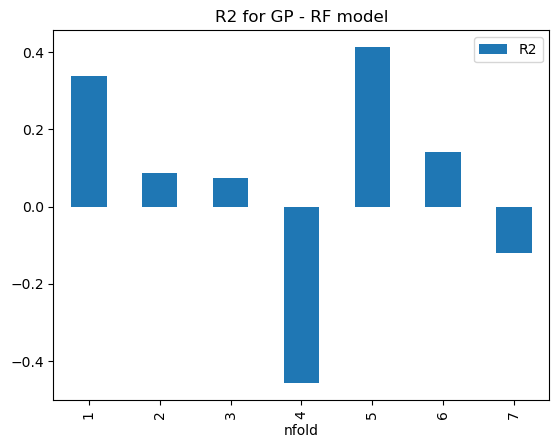

Image files generated:  ['pred_vs_trueOC.WB_combined.png', 'Xvalidation_Residual_hist_OC.WB.png']
Best R2 result for X-val fold: 5
Worst R2 result for X-val fold: 4


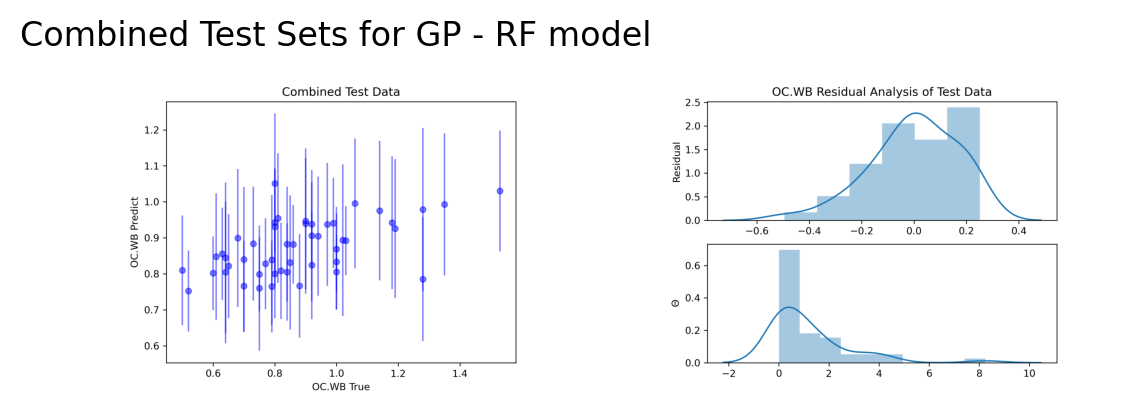

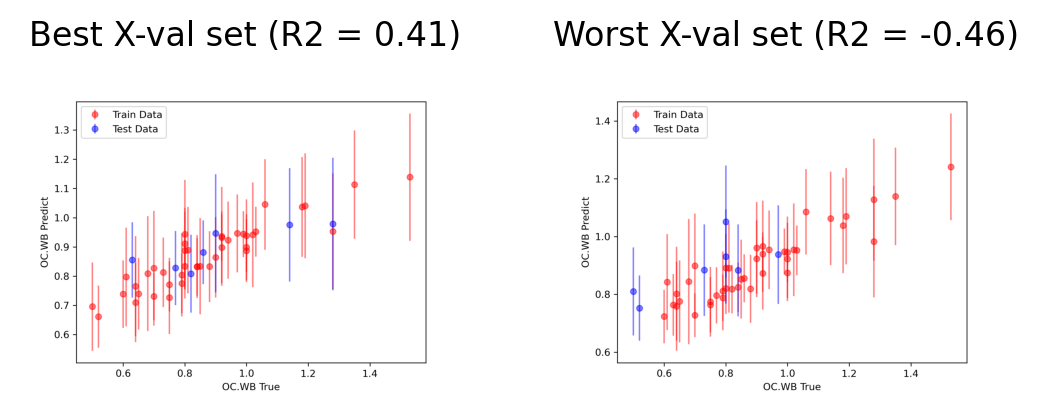

In [79]:
# Read in summary stats
modelname = 'GP - RF model'
respath = os.path.join(settings.outpath, 'Xval_7-fold_rf-gp_OC.WB')

dfstats = pd.read_csv(os.path.join(respath,'OC.WBnfold_summary_stats.csv'))

# print mean nRMSE and R2
print(f'---- Summary stats for {modelname} model ----')
print(f'Mean normalized RMSE = {np.mean(dfstats.nRMSE):.3f} +/- {np.std(dfstats.nRMSE):.3f}')
print(f'Mean R2 = {np.mean(dfstats.R2):.3f} +/- {np.std(dfstats.R2):.3f}')
print(f'Mean Theta = {np.mean(dfstats.Theta):.3f} +/- {np.std(dfstats.Theta):.3f}')

dfstats.plot(y='R2', x = 'nfold', kind = 'bar', title = f'R2 for {modelname}')
plt.show()

# Plot combined test data
files = os.listdir(respath)
pngfiles = [name for name in files if name.endswith('.png')]
print('Image files generated: ', pngfiles)
fig, ax = plt.subplots(1,2, dpi =200)
img = imread(f"{respath}/pred_vs_trueOC.WB_combined.png", format='PNG')
ax[0].set_axis_off()
ax[0].imshow(img)
ax[0].set_title(f'Combined Test Sets for {modelname}')
img2 = imread(f"{respath}/Xvalidation_Residual_hist_OC.WB.png", format='PNG')
ax[1].set_axis_off()
ax[1].imshow(img2)
#ax[1].set_title('')
fig.show()

# Plot best and worst X-validation results based on R2
fold_top = dfstats.loc[np.argmax(dfstats.R2), 'nfold']
print('Best R2 result for X-val fold:', fold_top)
fold_bottom = dfstats.loc[np.argmin(dfstats.R2), 'nfold']
print('Worst R2 result for X-val fold:', fold_bottom)

fig, ax = plt.subplots(1,2, dpi =200)
img = imread(f"{respath}/nfold_{fold_top}/pred_vs_trueOC.WB_nfold{fold_top}.png", format='PNG')
ax[0].set_axis_off()
ax[0].imshow(img)
ax[0].set_title(f'Best X-val set (R2 = {np.max(dfstats.R2):.2f})')
img2 = imread(f"{respath}/nfold_{fold_bottom}/pred_vs_trueOC.WB_nfold{fold_bottom}.png", format='PNG')
ax[1].set_axis_off()
ax[1].imshow(img2)
ax[1].set_title(f'Worst X-val set (R2 = {np.min(dfstats.R2):.2f})')
fig.show()


### Conclusions from cross-validation testing

The best model of all tested models is the GP with a Random Forest base function (R2 = 0.068 +/- 0.270). However due to the small sample size (20 for 2021 and 29 for 2018) and no significant correlation in OC between sample locations, the model is very limited in its predictive power.

## 3) Generate predictions maps and changes in OC

### Read and process settings

In [6]:
fname_settings = 'settings_soilmod_changepredict_OC.yaml'
path_settings = 'settings'

# Load settings from yaml file
with open(os.path.join(path_settings,fname_settings), 'r') as f:
    settings = yaml.load(f, Loader=yaml.FullLoader)
# Parse settings dictinary as namespace (settings are available as 
# settings.variable_name rather than settings['variable_name'])
settings = SimpleNamespace(**settings)

# Assume covariate grid file has same covariate names as training data
settings.name_features_grid = settings.name_features.copy()

# Rename temporal component
settings.colname_zcoord = settings.colname_tcoord
settings.zmin = settings.tmin
settings.zmax =  settings.tmax
settings.list_z_pred = settings.list_t_pred 
settings.zblocksize = settings.tblocksize

print("Main Settings:")
print("----------------")
for key in settings.__dict__:
    if key != "name_features":
        print(f"settings.{key} : {settings.__dict__[key]}")


Main Settings:
----------------
settings.inpath : ../../../data/Llara/OC_data_2018_2021/
settings.outpath : ../../../results/Llara_OC_2018_2021_rf-gp_changemaps_30m/
settings.infname : OC_NDVI_data_final.csv
settings.gridname : grid_NDVI_data_final.csv
settings.project_crs : EPSG:28355
settings.name_target : OC.WB
settings.model_function : rf-gp
settings.xyvoxsize : 30
settings.zvoxsize : 0.1
settings.colname_xcoord : Easting
settings.colname_ycoord : Northing
settings.axistype : temporal
settings.zmin : 2017
settings.zmax : 2022
settings.list_z_pred : [2018, 2021]
settings.colname_zcoord : year
settings.tmin : 2017
settings.tmax : 2022
settings.list_t_pred : [2018, 2021]
settings.colname_tcoord : year
settings.integrate_block : True
settings.xyblocksize : 30
settings.zblocksize : 0.1
settings.tblocksize : 0.1
settings.integrate_polygon : False
settings.polyname : testpolytri.gpkg
settings.name_features_grid : ['DEM_30', 'SlopeDeg', 'rad_dose', 'rad_u', 'NDVI_1yr']


In [7]:
# Print features selected
print("Features Selected:")
print("----------------")
for key in settings.__dict__:
    if key == "name_features":
        print(f"settings.{key}:")
        for feature in settings.name_features:
            print(f"   '{feature}'")

Features Selected:
----------------
settings.name_features:
   'DEM_30'
   'SlopeDeg'
   'rad_dose'
   'rad_u'
   'NDVI_1yr'


### Run predictions

This may take a while since the covariance between different times need to be calculated for each location.

In [8]:
if settings.integrate_block:
    # Only if block integration is set
    print('Generating Block Model and predictions for temporal slices...')
    mu_3d, std_3d = soilmod.model_blocks(settings)
else:
    # default model for point predictions
    print('Generating Point Model and predictions for temporal slices...')
    mu_3d, std_3d = soilmod.model_points(settings)

print("Prediction Mean, Median, Std, 25Perc, 75Perc:", np.round([np.nanmean(mu_3d), np.median(mu_3d[~np.isnan(mu_3d)]), 
    np.nanstd(mu_3d), np.percentile(mu_3d[~np.isnan(mu_3d)],25), np.percentile(mu_3d[~np.isnan(mu_3d)],75)] 
    ,3))
print("Uncertainty Mean, Median, Std, 25Perc, 75Perc:", np.round([np.nanmean(std_3d), np.median(std_3d[~np.isnan(std_3d)]),
    np.nanstd(std_3d), np.percentile(std_3d[~np.isnan(std_3d)],25), np.percentile(std_3d[~np.isnan(std_3d)],75)],3))
print('')
print('Predictions finished')
print(f'All results are saved in output directory {settings.outpath}')


Generating Block Model and predictions for temporal slices...
Number of evaluation points per block:  1.0
--- Parameter Settings ---
Model Function: rf-gp
Target Name: OC.WB
Prediction geometry: Volume
x,y,z blocksize: (30, 30, 0.1)
--------------------------
Reading in data...
Optimizing GP hyperparameters...
Mean Input Noise:  1.199484876417287
Optimized Hyperparameters (amplitude, y_noise_fac, lengthscale_z, lengths_xy): [1.00595490e-02 1.66100351e-04 1.03285250e-01 3.00000000e+04]
Marginal Log Likelihood:  -63.91926569017108
Computing block average and time change ... 


  0%|          | 248/80764 [00:00<01:05, 1237.62it/s]

Logl:  -63.91926569017108


100%|██████████| 80764/80764 [59:46<00:00, 22.52it/s]  


Prediction Mean, Median, Std, 25Perc, 75Perc: [0.88  0.883 0.077 0.82  0.93 ]
Uncertainty Mean, Median, Std, 25Perc, 75Perc: [0.057 0.056 0.013 0.049 0.064]

Predictions finished
All results are saved in output directory ../../../results/Llara_OC_2018_2021_rf-gp_changemaps_30m/


## Show Results

Here we show some of the prediction results.

### List of output files

This includes images as png as well as geo-referenced `.tif` images that can be used for further processing or GIS analysis

In [9]:
imgpath = os.path.join(settings.outpath, 'Figures_zslices')
files = os.listdir(imgpath)
#allfiles = [name for name in files if name.endswith('.png')]
print('Image files generated: ', files)

Image files generated:  ['Pred_OC.WB_dt.tif', 'Std_OC.WB_t201800.tif', 'Pred_OC.WB_t201800.png', 'Pred_OC.WB_t202100.png', 'Std_OC.WB_t202100.tif', 'Pred_OC.WB_t202100.tif', 'Pred_OC.WB_coord_x.txt', 'Std_OC.WB_dt.tif', 'Pred_OC.WB_dt_2021-2018.png', 'Pred_OC.WB_t201800.tif', 'Pred_OC.WB_coord_y.txt']


### Prediction maps for change in Organic Carbon from 2018 to 2021





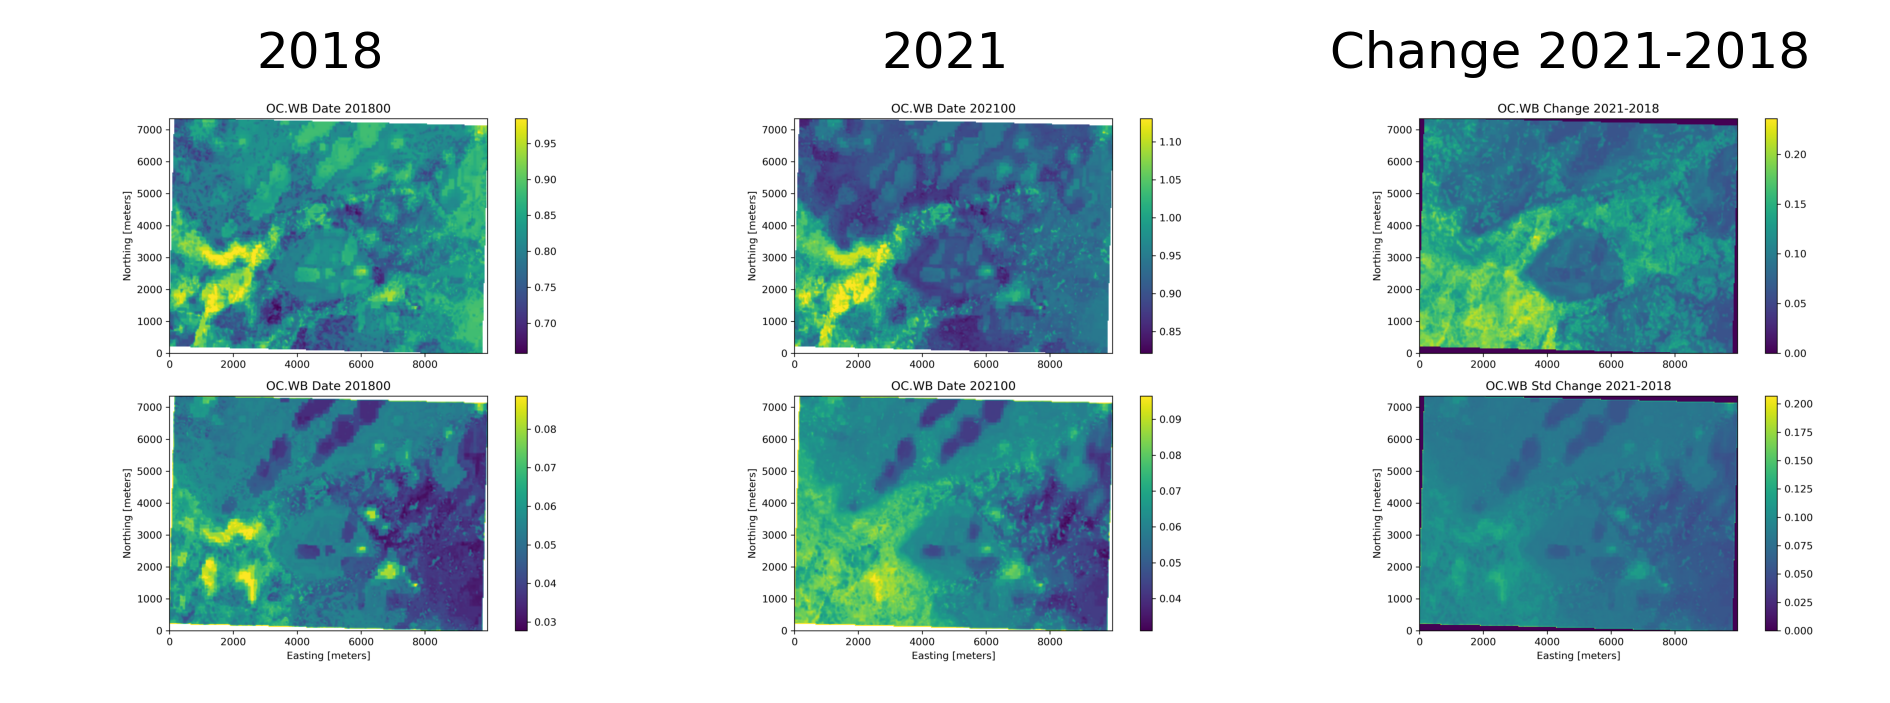

In [10]:
    fig, ax = plt.subplots(1,3, dpi =300)
    img = imread(f"{imgpath}/Pred_OC.WB_t201800.png", format='PNG')
    ax[0].set_axis_off()
    ax[0].imshow(img)
    ax[0].set_title('2018')
    img2 = imread(f"{imgpath}/Pred_OC.WB_t202100.png", format='PNG')
    ax[1].set_axis_off()
    ax[1].imshow(img2)
    ax[1].set_title('2021')
    img3 = imread(f"{imgpath}/Pred_OC.WB_dt_2021-2018.png", format='PNG')
    ax[2].set_axis_off()
    # flip image vertical
    ax[2].imshow(img3)
    ax[2].set_title('Change 2021-2018')
    plt.tight_layout()
    fig.show()